# 1. Approximate Inference and Logistic Regression
Implement regression solvers that use Newton-Rhapson to find the MLE and MAP estimates of the weights, respectively.

### (i) Implement a regression solver using maximum likelihood.

In [16]:
import numpy
import math

def MLElogReg(features, targets, epsilon = math.exp(-20), prior = None):
    """ Estimates MLE logistic regression weights using Newton-Rhapson. """
    
    # generate an initial weight vector of random values between 0 and 1
    weights = numpy.zeros(features.shape[1])
    # initialize change to none
    delta = None
    priorprob = 1
    
    # update the weights until delta is less than epsilon
    while not delta or (delta >= epsilon):
        # if there is a prior variance given, update the prior probability of the weights
        if prior is not None:
            priorprob = (math.sqrt(2*math.pi*numpy.linalg.det(prior))
                         *numpy.exp(-numpy.dot(numpy.transpose(weights), numpy.dot(prior, weights))/2))
        # find the gradient vector according to the equation we discussed in class
        gradient = priorprob*(numpy.dot(numpy.transpose(targets),features) -
                    numpy.dot(numpy.transpose(features), 1/(1+numpy.exp(-numpy.dot(features, numpy.transpose(weights))))))
        # use that to find the probability of each instance
        P = 1/(1+numpy.exp(-numpy.dot(features, weights)))
        # which can be used to calculate the Hessian matrix
        Hessian = -priorprob*numpy.dot(numpy.transpose(features), numpy.dot(numpy.dot(P, (1-P)), features))
        # calculate the change in the weight vector
        d = numpy.dot(numpy.linalg.inv(Hessian), gradient)
        # calculate the total change to compare to epsilon
        delta = numpy.sum(numpy.absolute(d))
        # generate the new weight vector
        weights = weights - d
    
    # return the final optimized weights
    return weights

### (ii) Implement a regression solver using a Normal prior. Approximate the posterior using Laplace approximation.

In [8]:
def BayeslogReg(features, targets, priorvar, epsilon = math.exp(-20)):
    """ Estimate logistic regression weights from a Normal prior. """
    
    # first we'll use Newton-Rhapson, as above to find the MAP estimates of w, which serve as the posterior mean
    MAPw = MLElogReg(features, targets, epsilon, prior = priorvar)
    
    # the posterior variance is the negative inverse Hessian
    # to find that first we must find the probability of each instance to calculate the MAP variance
    P = 1/(1+numpy.exp(-numpy.dot(features, MAPw)))
    # once I find that, I can calcualte the Hessian as discussed in class
    Hessian = -numpy.linalg.inv(priorvar) - numpy.dot(numpy.transpose(features), numpy.dot(numpy.dot(P, (1-P)), features))
    
    # and now I can return the estimated posterior mean and variance
    return MAPw, -numpy.linalg.inv(Hessian)

## a) Test your solver on some of the binary classification datasets we have used before.

First, I need to be able to predict the probability that an instance belongs to class 1.

In [3]:
def predictMLE(features, weights):
    """ Calculate the probability that each instance is in class 1 using the provdied weights. """
    return 1/(1+numpy.exp(-numpy.dot(features, numpy.transpose(weights))))


def predictBayes(features, mu, sigma, trials = 100):
    """ Sample weights from the approximated posterior, compute probabilities, and average them over samples. """
    
    # numpy array to hold the probability that an instance is in class 1 given each generated set of weights
    prob1 = numpy.empty((features.shape[0], trials))
    
    # generate the user provided number of weights from the distribution and fit the data
    for t in range(trials):
        # generate a new set of weights from the distribution
        weights = numpy.random.multivariate_normal(mu, sigma)
        # calculate the probability that each instance is a 1 using the same equation as MLE
        prob1[:, t] = predictMLE(features, weights)
    
    # average over all of the trials for each instance
    return numpy.mean(prob1, axis = 1)

Now I can classify instances using MLE and a prior.

In [19]:
# load up some binary classification data sets and test on those
for dataset in ["S1", "S2", "cancer"]:
    print(dataset)
    # clean up the cancer data set for use
    if dataset == "cancer":
        testset = numpy.loadtxt("cancer_test.csv", delimiter = ",", skiprows = 1)[:, 1:]
        trainset = numpy.loadtxt("cancer_train.csv", delimiter = ",", skiprows = 1)[:, 1:]
    else:
        testset = numpy.loadtxt(dataset+"test.csv", delimiter = ",")
        trainset = numpy.loadtxt(dataset+"train.csv", delimiter = ",")
    # make sure the labels are 1s and 0s
    testset[:, 0] = 1*(testset[:, 0] == 1)
    trainset[:, 0] = 1*(trainset[:, 0] == 1)
    # calculate the MLE weights
    MLEweights = MLElogReg(trainset[:, 1:], trainset[:, 0])
    # find the probability each instance is in class 1 with MLE
    MLEclasses = predictMLE(testset[:, 1:], MLEweights)
    # print out the misclassification rate
    print("MLE misclassification: " + str(numpy.mean(1*(1*(MLEclasses > .5) != testset[:, 0]))))
    # find the Normal parameters
    Bmu, Bsigma = BayeslogReg(trainset[:, 1:], trainset[:, 0],
                              numpy.amax(MLEweights)*numpy.identity(trainset.shape[1]-1))
    # approximate the posterior predictive probability of each test instance
    Bclasses = predictBayes(testset[:, 1:], Bmu, Bsigma)
    # print out the misclassification rate
    print("Bayesian misclassification: " + str(numpy.mean(1*(1*(Bclasses > .5) != testset[:, 0]))))
    print()

S1
MLE misclassification: 0.225
Bayesian misclassification: 0.224

S2
MLE misclassification: 0.283
Bayesian misclassification: 0.283

cancer
MLE misclassification: 0.145922746781
Bayesian misclassification: 0.141630901288



## b) For the 2D synthetic data, produce a plot of the data, color-coded by class and by predicted class probabilities according to the MLE and Bayesian solvers.

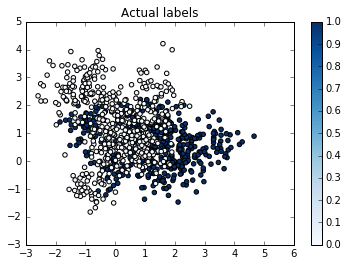

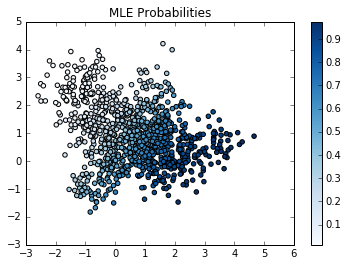

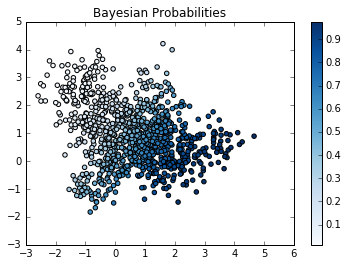

In [20]:
import matplotlib.pyplot as plt

def plotProbs(features, classes, title):
    """ Plots instances by their features, colored according to the probability of belonging to class 1. """
    
    plt.scatter(features[:, 0], features[:, 1], c = classes, cmap = "Blues")
    plt.colorbar()
    plt.title(title)
    plt.show()


# load the data and display the testset
S2test = numpy.loadtxt("S2test.csv", delimiter = ",")
S2train = numpy.loadtxt("S2train.csv", delimiter = ",")
S2test[:, 0] = numpy.equal(S2test[:, 0], 1)*1
S2train[:, 0] = numpy.equal(S2train[:, 0], 1)*1
plotProbs(S2test[:, 1:], S2test[:, 0], "Actual labels")

# find the MLE weights and display the probabilities based on those
weights = MLElogReg(S2train[:, 1:], S2train[:, 0])
MLEprobs = predictMLE(S2test[:, 1:], weights)
plotProbs(S2test[:, 1:], MLEprobs, "MLE Probabilities")

# find the Bayesian probabilities
mu, sigma = BayeslogReg(S2train[:, 1:], S2train[:, 0], numpy.amax(weights)*numpy.identity(S2train.shape[1]-1))
Bprobs = predictBayes(S2test[:, 1:], mu, sigma)
plotProbs(S2test[:, 1:], Bprobs, "Bayesian Probabilities")

## c) Comment on the differences between the MLE and posterior-predictive methods.

The primary difference between the two methods is that MLE provides an exact point estimate for the weights. It uses the weights that maximize likelihood and throws out the rest. The posterior-predictive method, on the other hand, uses the MLE estimate of the weights and uses them to find the parameters for the distribution that the weights are drawn from. This incorporates some of the uncertainty as to the actual weights, but at the expense of the certainty provided by the MLE solution - some weights drawn from the distribution will be better than others and averaging over multiple draws doesn't remove that entirely. In terms of performance, the posterior-predictive method performed a little better on the cancer dataset, but was the same as MLE on the two synthetic data sets.

## d) Evaluate the two models on the test sets for the 2-dimensional synthetic data set and the cancer data set using a weighted misclassification rate.

In [21]:
# evaluate the MLE predictions
print("MLE: " + str(numpy.mean(numpy.absolute(targets-MLEprobs))))
# and the posterior-predictive
print("Posterior-predictive: " + str(numpy.mean(numpy.absolute(targets-Bprobs))))

MLE: 0.361861289708
Posterior-predictive: 0.361844238333


# 2. Laplace Approximation for a Beta Distribution.
Find a formula for the Laplace approximation to a Beta distribution and plot the approximation
against the true density.

A Beta distribution takes the form
$$ p(x|a, b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}x^{a-1}(1-x)^{b-1} $$
To find the closest Normal, we must find the normal whose Taylor expansion most closely matches the Taylor expansion of the Beta distribution in the leading terms.
The Taylor expansion of a normal takes the form
$$ c - \frac{(x-\mu)^2}{2\sigma^2} $$
The first three terms of Taylor expansion of the Beta are
$$ \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}(\hat{x}^{a-1}(1-\hat{x})^{b-1} + 0 + \frac{(x-\hat{x})^2}{2}((a-1)(a-2)\hat{x}^{a-3}(1-\hat{x})^{b-1} - 2(a-1)\hat{x}^{a-2}(b-1)(1-\hat{x})^{b-2} + \hat{x}^{a-1}(b-1)(b-2)(1-\hat{x})^{b-3})) $$
Where $ \hat{x} $ is a maximum.

$$ \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}(\hat{x}^{a-1}(1-\hat{x})^{b-1}) $$
is a constant, so we are left with
$$ c + \frac{(x-\hat{x})^2}{2}\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}((a-1)(a-2)\hat{x}^{a-3}(1-\hat{x})^{b-1} - 2(a-1)\hat{x}^{a-2}(b-1)(1-\hat{x})^{b-2} + \hat{x}^{a-1}(b-1)(b-2)(1-\hat{x})^{b-3}) $$

This resembles the Taylor expansion of the Normal with $ \mu = \hat{x} $ and
$$ \sigma^2 = -\frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}\frac{1}{(a-1)(a-2)\hat{x}^{a-3}(1-\hat{x})^{b-1} - 2(a-1)\hat{x}^{a-2}(b-1)(1-\hat{x})^{b-2} + \hat{x}^{a-1}(b-1)(b-2)(1-\hat{x})^{b-3}} $$

## a) Plot the Laplace approximation of a Beta distribution with $ a = 10 $ and $ b = 10 $ against the true density.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


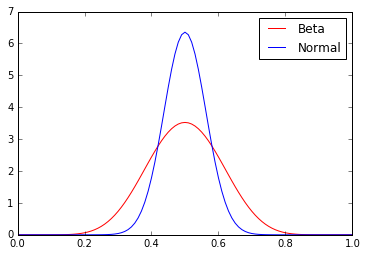

In [186]:
import math
import matplotlib.pyplot as plt
import numpy

def LaplaceBeta(a, b):
    """ Plots the Laplace approximation of a Beta distribution against the true density """
    
    # calculate the maximum of the Beta distribution, which will be the mean of the approximation
    mu = (a-1)/(a+b-2)
    # use that to calculate the variance
    sigma = -(math.exp(math.lgamma(a)+math.lgamma(b)-math.lgamma(a+b))/
              ((a-1)*(a-2)*(mu**(a-3))*((1-mu)**(b-1)) - 2*(a-1)*(mu**(a-2))*(b-1)*((1-mu)**(b-2)) +
               (mu**(a-1))*(b-1)*(b-2)*((1-mu)**(b-3))))
    # generate a range of values to plot the distributions across
    x = numpy.arange(0, 1.01, .01)
    # now I can plot a Beta and a Normal
    plt.plot(x, numpy.exp(math.lgamma(a+b)-(math.lgamma(a)+math.lgamma(b))+(a-1)*numpy.log(x)+(b-1)*numpy.log(1-x)), 'r',
            x, numpy.exp(-((x-mu)**2)/(2*sigma))/(math.sqrt(2*math.pi*sigma)), 'b')
    plt.legend(["Beta", "Normal"])
    plt.show()

LaplaceBeta(10, 10)

## b) Plot the Laplace approximation of a Beta distribution with $ a = 5 $ and $ b = 15 $ against the true density.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


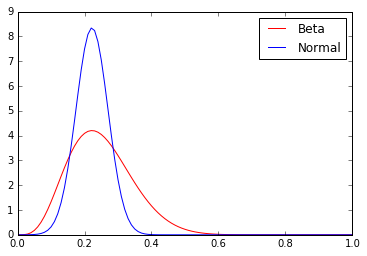

In [187]:
LaplaceBeta(5, 15)

## c) Plot the Laplace approximation of a Beta distribution with $ a = 2 $ and $ b = 18 $ against the true density.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


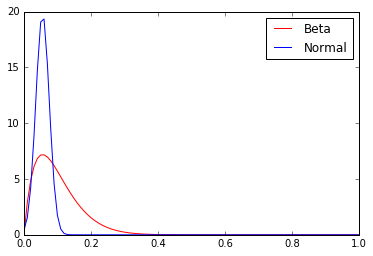

In [188]:
LaplaceBeta(2, 18)

## d) Plot the Laplace approximation of a Beta distribution with $ a = 20 $ and $ b = 180 $ against the true density.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


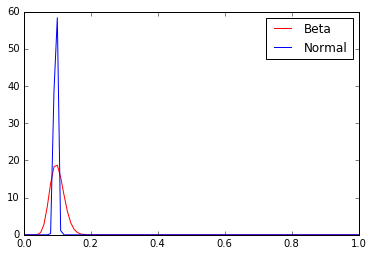

In [189]:
LaplaceBeta(20, 180)

# 3. Clustering with a Gaussian Mixture Model and the EM algorithm.

Implement the EM algorithm to find local maximum likelihood parameter values for a Gaussian Mixture model with a fixed number of clusters.

In [65]:
import numpy
import math
import random

def Kmeans(data, K):
    """ Initializes the clusters intelligently using K-means. """
    
    # randomly generate K means
    means = []
    for k in range(K):
        meank = []
        # for each attribute, generate a mean between the min and max value of that attribute
        for col in range(data.shape[1]):
            meank.append(random.uniform(numpy.amin(data[:, col]), numpy.amax(data[:, col])))
        # add this mean to the list
        means.append(meank)
    means = numpy.array(means)
    
    # store whether the cluster assignments have been changed in a given iteration
    changed = True
    
    # while the cluster assignments are still changing, assign values to their nearest cluster and calculate new means
    while changed:
        # set changed to False for this round
        changed = False
        
        # calculate the Euclidian distance from each instance to each cluster mean
        dists = numpy.empty((data.shape[0], K))
        for k in range(K):
            dists[:, k] = numpy.apply_along_axis(lambda x: math.sqrt(numpy.sum((x-means[k, :])**2)), 1, data)
        
        # find the nearest cluster center for each instance
        clusters = numpy.argmin(dists, axis = 1)
        
        # calculate the new mean of each cluster
        for k in range(K):
            clusterk = 1*(clusters == k)
            # if this cluster doesn't have any instances in it, try again
            if numpy.sum(clusterk) == 0:
                return Kmeans(data, K)
            # loop through each attribute
            for col in range(data.shape[1]):
                meanka = numpy.sum(data[:, col]*clusterk)/numpy.sum(clusterk)
                # if the new mean of this cluster is different from the old mean, turn changed to true
                if meanka != means[k, col]:
                    changed = True
                # add the new mean to the array
                means[k, col] = meanka
    
    # once the cluster assignments stop changing, return the assignments and the means
    return clusters, means
        

In [86]:
import scipy.stats as scistats

def EM(data, K, clusters, epsilon=.0001):
    """ Splits data into K Normal clusters using the EM algorithm. """
    
    # initialize the cluster assignments based on the results of K-means
    q = numpy.empty((data.shape[0], K))
    for k in range(K):
        q[:, k] = 1*(clusters == k)
    # initialize the mean of each attribute in each cluster to random values that will be changed soon anyway
    mu = numpy.empty((K, data.shape[1]))
    # and a matrix of variances
    sigma = numpy.empty((K, data.shape[1], data.shape[1]))
    # and an array of cluster weights
    pi = numpy.empty(K)
    # keeps track of how much the parameters change in a given round
    delta = None
    # an array to hold the log-likelihood of each iteration
    likelihood = []
    
    # now update the parameters until the change in all of them drops below epsilon
    while not delta or (delta >= epsilon):
            
        # adjust the parameters for each cluster
        for cluster in range(K):
            pi[cluster] = numpy.sum(q[:, cluster])/data.shape[0]
            mu[cluster, :] = numpy.dot(numpy.transpose(data), q[:, cluster])/numpy.sum(q[:, cluster])
            sigma[cluster, :, :] = numpy.dot(numpy.transpose(data-mu[cluster, :]), data-mu[cluster, :])/numpy.sum(q[:, cluster])
            # now I can update the unormalized q value of each instance for this cluster using the built in pdf function
            q[:, cluster] = numpy.log(pi[cluster])+numpy.apply_along_axis(lambda d: scistats.multivariate_normal.logpdf(
                d, mean = mu[cluster, :], cov = sigma[cluster, :, :]), 1, data)
            q[:, cluster] = numpy.exp(q[:, cluster]-numpy.mean(q[:, cluster]))
            # normalize the q values
        
        q = numpy.apply_along_axis(lambda w: w/numpy.sum(q, axis = 1), 0, q)
        # calculate the likelihood for this iterration
        likelihood.append(numpy.sum(numpy.log(numpy.apply_along_axis(lambda d: d*pi, 1, q))))
        # calculate the difference between the likelihood of this iteration and the previous
        if len(likelihood) > 1:
            delta = numpy.absolute(likelihood[-1]-likelihood[-2])
            
    
    # now we can return the final parameter values and likelihood
    return mu, sigma, pi, q, likelihood

## a) Plot 2-dimensional data, color coded by maximum posterior cluster.

In [87]:
import matplotlib.pyplot as plt

def plotClusters(data, q):
    """ Plots data colored by cluster. """
    cluster = numpy.argmax(q, axis = 1)
    plt.scatter(data[:, 0], data[:, 1], c = cluster, cmap = "Set1")
    plt.title("Clusters")
    plt.show()

## b) Test your model with various values of K and initializations on the petal dimensions of the iris data. Plot the training set loglikelihood for each iteration.

In [88]:
# load the iris data
irisfeats = numpy.loadtxt("iris_features.csv", delimiter = ",", skiprows = 1)
# create a copy that won't get shuffled for use later
irisdata = numpy.copy(irisfeats)

# cluster data and display the K-means clusters, the EM clusters, and the log likelihood over the course of EM
def cluster(data, clusternum):
    clusters, means = Kmeans(data, clusternum)
    plt.scatter(data[:, 0], data[:, 1], c = clusters, cmap = "Set1")
    plt.title("K-Means Clusters")
    plt.show()
    mu, sigma, pi, q, likelihood = EM(data, clusternum, clusters)
    plotClusters(data, q)
    plt.plot(numpy.arange(len(likelihood)), likelihood)
    plt.ylabel("Log Likelihood")
    plt.xlabel("Iteration")
    plt.title("Log Likelihood")
    plt.show()

2 clusters:

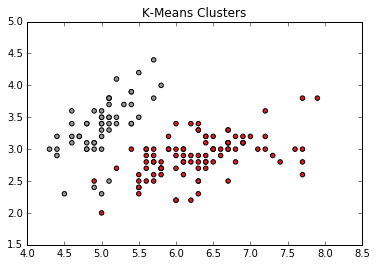

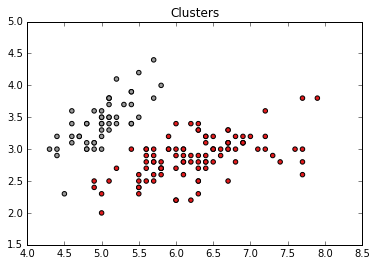

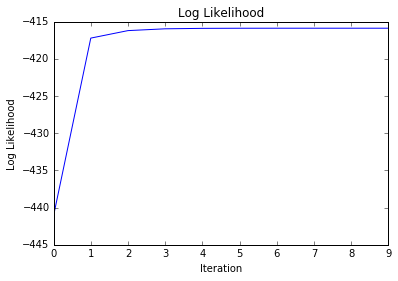

In [89]:
cluster(irisfeats, 2)

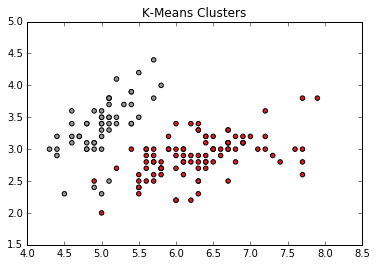

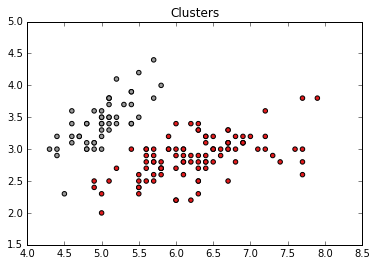

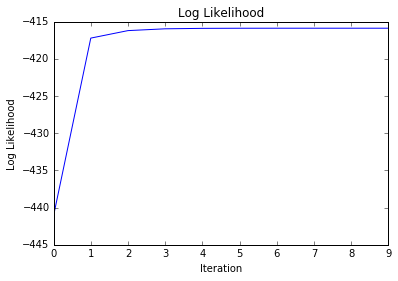

In [93]:
cluster(irisfeats, 2)

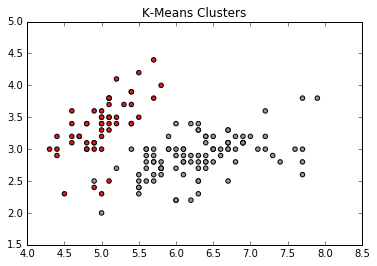

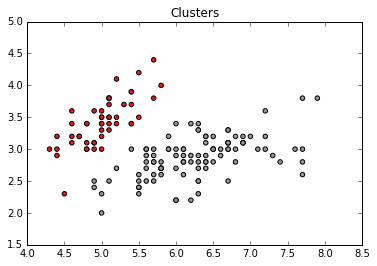

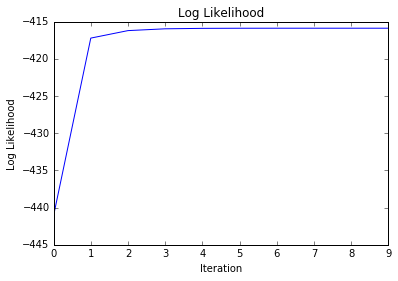

In [94]:
cluster(irisfeats, 2)

3 clusters:

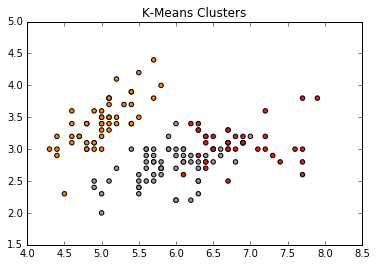

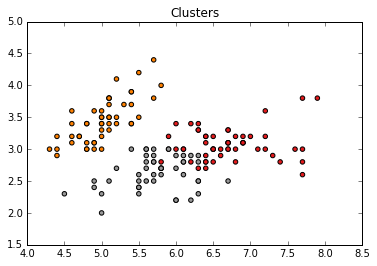

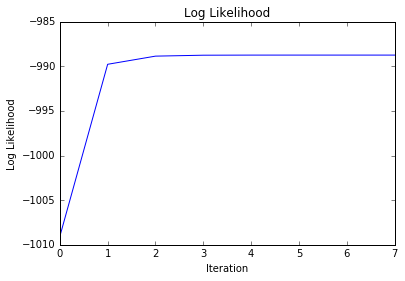

In [90]:
cluster(irisfeats, 3)

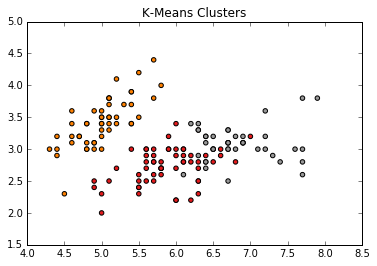

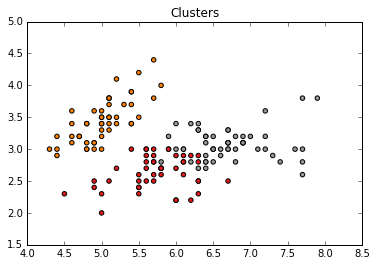

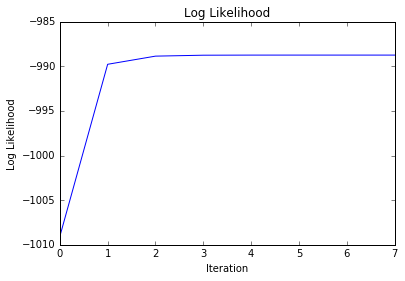

In [95]:
cluster(irisfeats, 3)

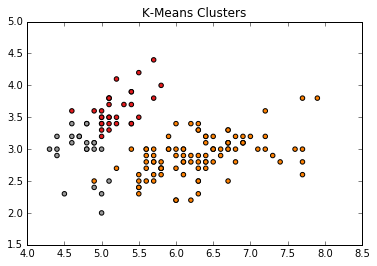

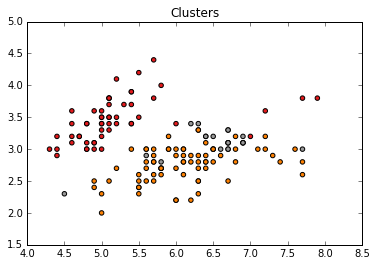

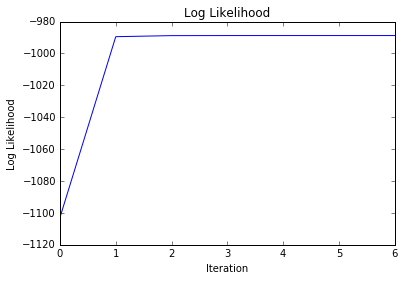

In [96]:
cluster(irisfeats, 3)

4 clusters:

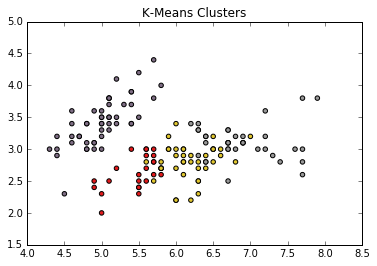

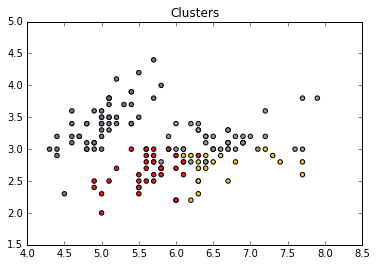

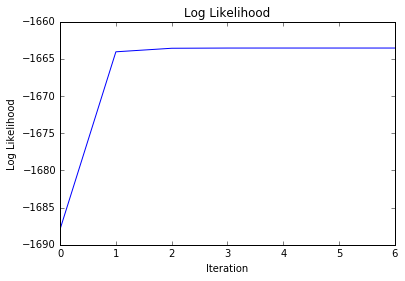

In [91]:
cluster(irisfeats, 4)

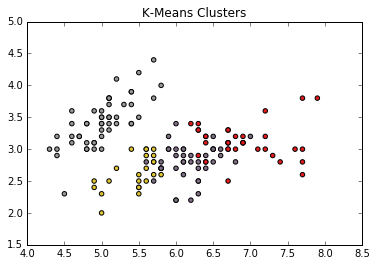

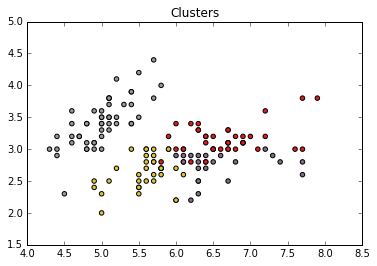

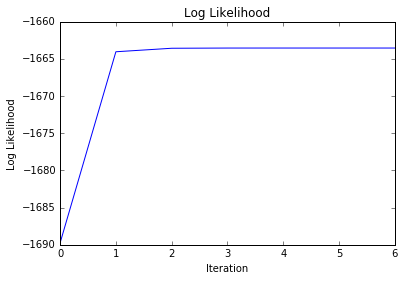

In [97]:
cluster(irisfeats, 4)

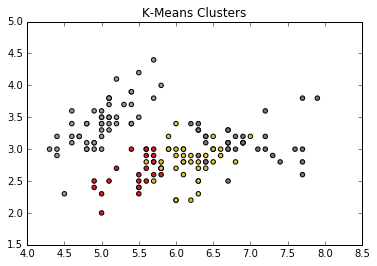

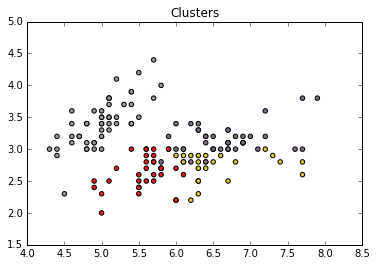

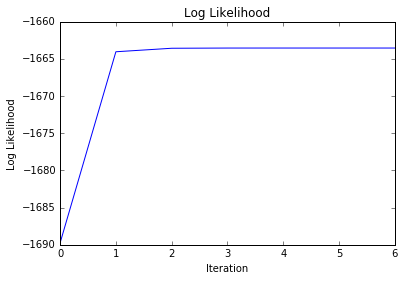

In [99]:
cluster(irisfeats, 4)

5 clusters:

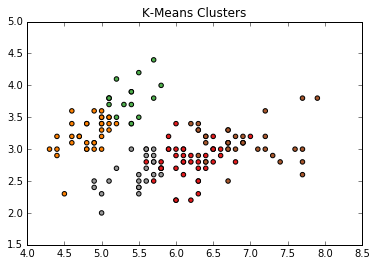

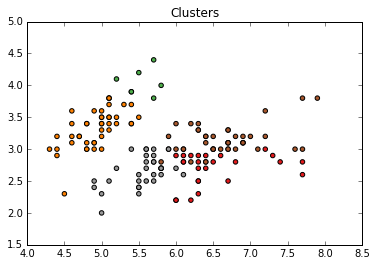

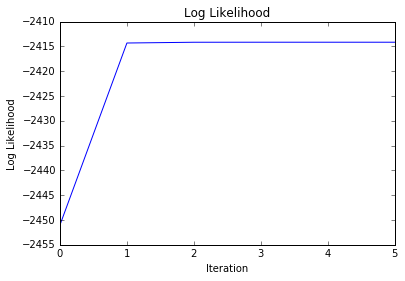

In [98]:
cluster(irisfeats, 5)

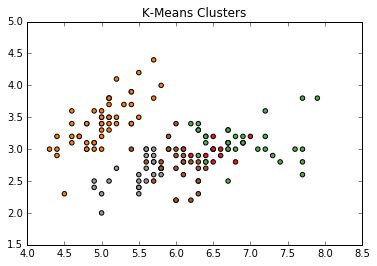

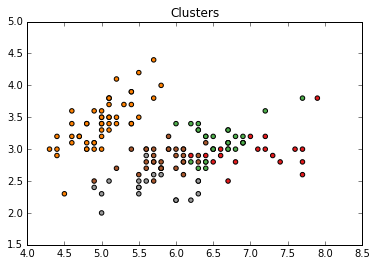

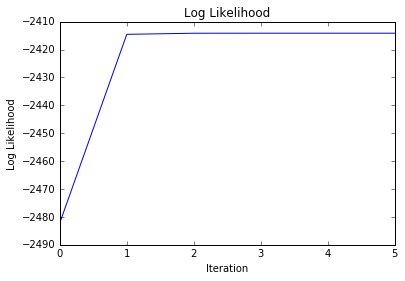

In [92]:
cluster(irisfeats, 5)

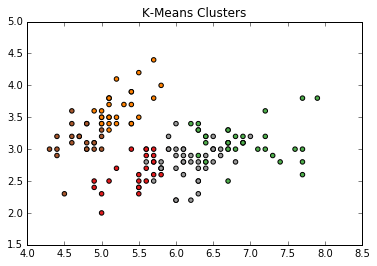

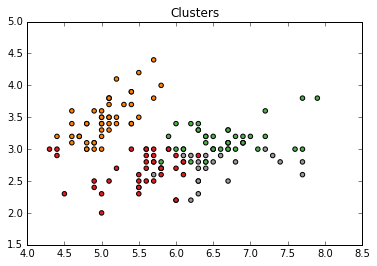

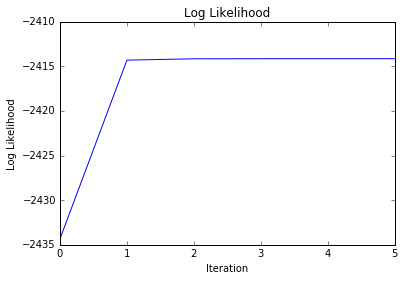

In [100]:
cluster(irisfeats, 5)

## c) Comment on how sensitive the algorithm is to the initial conditions and what effect the choice of K has on final training log-likelihood.

For the most part, the clusters I found were practically identical, aside from cluster identities, regardless of initial conditions. There were a few exceptions to this, notably when K was equal to 3 and 5. The fact that the clusters were the same otherwise is probably in large part a result of the fact that I initialized the clusters using K-means, which found similar results for most initializations. When I fed those clusters into the EM algorithm, it made them even more similar.
Technically, the log-likelihood of each cluster should increase as K increases because each cluster contains fewer instances and is therefore better able to fit them. However, as the above graphs show, final training log-likelihood greatly increased as K increased. I don't know why.


# 4. Cross-Validation in Clustering.
Implement 10-fold cross-validaiton to select the best value of K by maximizing mean log-likelihood on the validation set.

In [101]:
def crossvalidClusters(data, K):
    """ Runs 10-fold cross-validation on a range of values of K to determine which number of clusters is best. """
    
    # shuffle the data
    numpy.random.shuffle(data)
    # split it into 10 folds
    basesize = int(data.shape[0]/10)
    leftovers = data.shape[0]%10
    foldstart = 0
    
    # list of training likelihood for each k
    trainlikelihood = numpy.zeros(len(K))
    # and validation likelihood
    validlikelihood = numpy.zeros(len(K))
    
    # run cross-validation on each fold for each value of K
    for fold in range(10):
        # determine where this fold ends
        foldend = foldstart + basesize
        if fold < leftovers:
            foldend += 1
        # actually grab the validation and training sets
        validset = data[foldstart:foldend, :]
        trainset = numpy.append(data[:foldstart, :], data[foldend:, :], axis = 0)
        
        # loop through a range of K values
        for kdex in range(len(K)):
            k = K[kdex]
            # run K-means to initialize the clusters
            clusters, means = Kmeans(trainset, k)
            # run EM to get the parameter values and likelihood of the training instances
            mu, sigma, pi, q, likelihood = EM(trainset, k, clusters)
            # grab the latest likelihood
            trainlikelihood[kdex] += likelihood[-1]/trainset.shape[0]
            # calculate the posterior predictive probability of each class
            pospred = numpy.empty((validset.shape[0], k))
            for c in range(k):
                pospred[:, c] = numpy.log(pi[c])+numpy.apply_along_axis(lambda d: scistats.multivariate_normal.logpdf(
                    d, mean = mu[c, :], cov = sigma[c, :, :]), 1, validset)
            # calculate the log likelihood
            validlikelihood[kdex] += numpy.mean(numpy.amax(pospred, axis = 1))
        
        # increment fold start
        foldstart = foldend
    
    # average the likelihoods over folds and return
    return trainlikelihood/10, validlikelihood/10

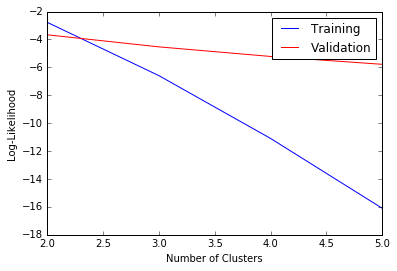

In [103]:
K = range(2, 6)
# run cross-validation on the iris data
trainl, validl = crossvalidClusters(irisfeats, K)
# plot it
plt.plot(K, trainl, "b", K, validl, "r")
plt.legend(["Training", "Validation"])
plt.xlabel("Number of Clusters")
plt.ylabel("Log-Likelihood")
plt.show()

10-fold cross-validation finds that the optimal number of clusters is 2. They look like:

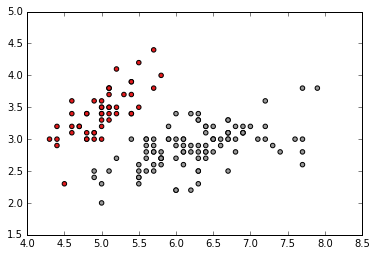

In [105]:
clusters, means = Kmeans(irisfeats, k)
mu, sigma, pi, q, likelihood = EM(irisfeats, k, clusters)
plt.scatter(irisfeats[:, 0], irisfeats[:, 1], c = numpy.argmax(q, axis = 1), cmap = "Set1")
plt.show()

In [ ]:
The data actually consists of 3 different species of flower. For comparison, the actual classes are:

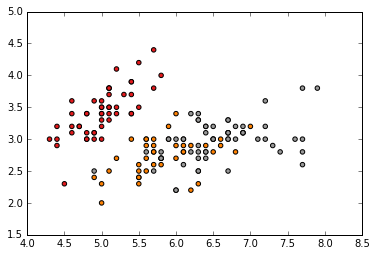

In [114]:
# load the classes
irisl = numpy.loadtxt("iris_labels.csv", delimiter = ",", dtype = str, skiprows = 1)
iriscats, irislabels = numpy.unique(irisl, return_inverse = True)
# and plot them
plt.scatter(irisdata[:, 0], irisdata[:, 1], c = irislabels, cmap = "Set1")
plt.show()

The optimal clusters discover the species setosa, but lump together virginica and versicolor.

# 5. Applying clustering to cancer microarray data.

In [118]:
import numpy

# load the data
cancerred = numpy.loadtxt("nci60_reduced.csv", skiprows = 1, delimiter = ",")
# and a copy to use later
cancerdata = numpy.copy(cancerred)

## a) Using a Gaussian Mixture Model, estimate the parameters with the EM algorithm and use 10-fold cross-validation to find a suitable number of clusters. Plot the first two dimensions labeled by maximum likelihood cluster for the best value of K.

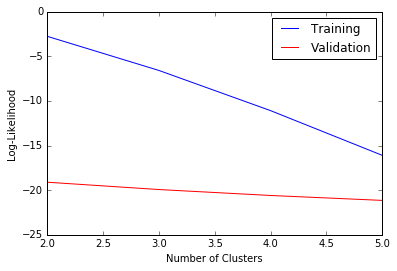

In [116]:
# 10-fold cross-validation
K = range(2, 6)
trainl, validl = crossvalidClusters(cancerred, K)
# plot it
plt.plot(K, trainl, "b", K, validl, "r")
plt.legend(["Training", "Validation"])
plt.xlabel("Number of Clusters")
plt.ylabel("Log-Likelihood")
plt.show()

As illustrated by the plot above, the optimal number of clusters is 2.

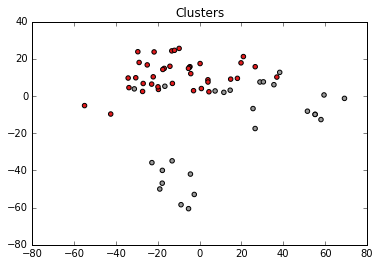

In [119]:
k = 2
clusters, means = Kmeans(cancerdata, k)
mu, sigma, pi, q, likelihood = EM(cancerdata, k, clusters)
plotClusters(cancerdata, q)

## a) Compare clusters to the human provided categories.

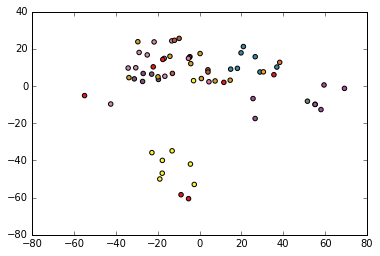

In [120]:
# load the labels
cancerl = numpy.loadtxt("nci60_labels.csv", dtype = str, skiprows = 1)
# grab the categories and their indices
cancercats, cancerlabels = numpy.unique(cancerl, return_inverse = True)
# plot it!
plt.scatter(cancerdata[:, 0], cancerdata[:, 1], c = cancerlabels, cmap = "Set1")
plt.show()

I found that the optimal number of clusters is 2, much less than the 14 actual categories. As a result, each actual category did not get its own cluster. Instead, my clusters can be evaluated on whether all of the members of each actual category were put into the same cluster - even if it also housed members of different categories.

In [137]:
# dictionary to match actual categories to a list of the clusters that contain them
clustercount = {}
# and the number of instances in them
catcount = {}
# grab the clusters
clusters = numpy.argmax(q, axis = 1)

# loop through each instance and add its maximum likelihood cluster and actual category to the dictionary
for i in range(cancerdata.shape[0]):
    # save the instance's actual label
    actl = cancerlabels[i]
    # and its maximum likelihood cluster
    cluster = clusters[i]
    # add the actual label to clustercount and catcount if necessary
    if actl not in clustercount:
        clustercount[actl] = [cluster]
        catcount[actl] = 0
    # otherwise just append the maximum likelihood cluster to the list (if it's not there already)
    elif cluster not in clustercount[actl]:
        clustercount[actl].append(cluster)
    # increment catcount
    catcount[actl] += 1

# loop through each cluster and print out the number of clusters it belongs to
print("Actual Category     Number of Clusters     Number of Instances")
for c in range(cancercats.shape[0]):
    print("%11s                 %i                      %i" % (cancercats[c].strip("b'" + '"'),
                                                               len(clustercount[c]), catcount[c]))

Actual Category     Number of Clusters     Number of Instances
     BREAST                 2                      7
        CNS                 2                      5
      COLON                 2                      7
K562A-repro                 1                      1
K562B-repro                 1                      1
   LEUKEMIA                 1                      6
MCF7A-repro                 1                      1
MCF7D-repro                 1                      1
   MELANOMA                 2                      8
      NSCLC                 2                      9
    OVARIAN                 1                      6
   PROSTATE                 1                      2
      RENAL                 2                      9
    UNKNOWN                 1                      1
